In [3]:
import os
import folder
import statistics as stat

import pandas as pd
import geopandas as gpd
import networkx as nx

pd.set_option("display.width", 320); pd.set_option('display.max_columns',12)

# set up and import data
os.chdir(folder.mob_dir)

feb_df = pd.read_csv("MA_cbg2cbg_2019_02.csv", low_memory=False)
apr_df = pd.read_csv("MA_cbg2cbg_2019_04.csv", low_memory=False)

In [4]:
# function to add a column with weight to the data
def add_weigth(df):
    for i in range(len(df)):
        df.loc[i, "flow"] = df.loc[i, "visitor_count"] / df.loc[i, "raw_device_counts"]
    print(df.columns)
    return df

# function to filter lines where both starting and destination are in MA
# here I print out the number of lines in the original and the new df
def filter_ma(df):
    df["poi_cbg"] = df["poi_cbg"].astype("string")
    df["visitor_census_tract"] = df["visitor_census_tract"].astype("string")
    ma_ind = df.index[(df["poi_cbg"].str[:2] == "25") & (df["visitor_census_tract"].str[:2] == "25")].tolist()
    ma_df = df.iloc[ma_ind].reset_index()
    print(f"Change in number of movements: {len(df)} -> {len(ma_df)}\n")
    return ma_df

feb_df, apr_df = add_weigth(feb_df), add_weigth(apr_df)
feb_ma, apr_ma = filter_ma(feb_df), filter_ma(apr_df)

Index(['poi_cbg', 'year_month', 'raw_device_counts', 'visitor_census_tract', 'visitor_count', 'flow'], dtype='object')
Index(['poi_cbg', 'year_month', 'raw_device_counts', 'visitor_census_tract', 'visitor_count', 'flow'], dtype='object')
Change in number of movements: 818861 -> 667830

Change in number of movements: 1011374 -> 791202



The first metric we can identify solely from the tables is the number of movements in the respective months (i.e., number of "edges" - which is the length of the original tables, feb_df and apr_df. Somewhat counter intuitively, the number of edges in apr is more than in feb, even when we take out all the out-of-state nodes (MA:25). Later we will see that this belies the decrease in connectedness of the movement network (a decrease in density). Also notable is the observation that most movements consistently (around 80%) happens within the city.

In [5]:
def unique_nodes(df):
    point_a = df["poi_cbg"].tolist()
    point_b = df["visitor_census_tract"].tolist()
    node_list = set(point_a).union(set(point_b))
    print(f"total unique nodes: {len(node_list)}\n"
          f"total unique starting nodes: {len(set(point_a))}\n"
          f"total unique destination nodes: {len(set(point_b))}\n")

unique_nodes(feb_df), unique_nodes(apr_df)
# unique_nodes(feb_ma), unique_nodes(apr_ma)

total unique nodes: 38554
total unique starting nodes: 4983
total unique destination nodes: 38548

total unique nodes: 53500
total unique starting nodes: 4984
total unique destination nodes: 53491



(None, None)

Here I check the number of unique nodes. Each month's results return two sets of numbers, one includeing out-of-state nodes and one only in MA. The number of unique nodes in apr is higher than in feb, driven mostly by the number of destination nodes. We can also compare this to the MA only dataset to guess that there has been an increase in out-of-state destination, likely as a result of people going back to their home states, or relocate for other reasons (such as escaping lockdowns)

In [6]:
stat.mean(feb_df.flow), stat.mode(feb_df.flow)

(0.005194382974190166, 5.442621166353716e-05)

In [7]:
stat.mean(apr_df.flow), stat.mode(apr_df.flow)

(0.004214316697723331, 3.615067601764153e-05)

Finally, as we can see, both the mean strength of movements (how many people are travelling), as well as the mode (the most frequent traveling size) of in april is less than in feb. This suggest that on average, less people are travelling. So even when there are more movements, these movements are less intense.

In [8]:
# create directed graphs
def add_directed_graph(df):
    dgr = nx.DiGraph()
    d_range = range(len(df))
    for i in d_range:
        a = df.loc[i, "poi_cbg"]
        b = df.loc[i, "visitor_census_tract"]
        flow = df.loc[i, "flow"]
        dgr.add_edge(a, b, weight = flow)
    print(f"directed network created: {dgr}")
    return dgr

feb_ma_g, apr_ma_g = add_directed_graph(feb_ma), add_directed_graph(apr_ma)

directed network created: DiGraph with 4984 nodes and 667830 edges
directed network created: DiGraph with 4985 nodes and 791202 edges


In [9]:
feb_ma_density, apr_ma_density = nx.density(feb_ma_g), nx.density(apr_ma_g)
print(feb_ma_density, apr_ma_density)

feb_g, apr_g = add_directed_graph(feb_df), add_directed_graph(apr_df)
feb_density, apr_density = nx.density(feb_g), nx.density(apr_g)
print(feb_density, apr_density)

0.026890383966803343 0.03184521461656237
directed network created: DiGraph with 38554 nodes and 818861 edges
directed network created: DiGraph with 53500 nodes and 1011374 edges
0.0005509124233837174 0.0003533558929304819


Here I compare the density of the different networks. Density is calculated as the proportion of total actual edges over total possible edges, which is n(n-1) where n is the number of nodes. As we can see, the density of total movement (the larger data set) shows a decrease in density while the smaller MA network shows an increase in density as people travel more frequently within the state as a result of the lockdown.

In [10]:
# create two table with list of nodes and there respective centrality
def centrality_table(dgr):
    in_deg = nx.in_degree_centrality(dgr)
    out_deg = nx.out_degree_centrality(dgr)
    closeness = nx.closeness_centrality(dgr)
    between = nx.betweenness_centrality(dgr)
    measures = [in_deg, out_deg, closeness, between]
    m_dict = {}
    for m in in_deg.keys():
        m_dict[m] = tuple(d[m] for d in measures)
    table = pd.DataFrame.from_dict(m_dict, orient="index").rename(columns={0: "in_degree",
                                                                           1: "out_degree",
                                                                           2: "closeness",
                                                                           3: "betweeness"})
    return table

feb_table, apr_table = centrality_table(feb_ma_g), centrality_table(apr_ma_g)
print(feb_table, apr_table)

              in_degree  out_degree  closeness  betweeness
250010110023   0.009432    0.014048   0.374089    0.000076
250010112004   0.012643    0.013646   0.373584    0.000065
250010110024   0.032109    0.023881   0.421547    0.000346
250010116003   0.015051    0.015653   0.386004    0.000186
250010112001   0.016857    0.019065   0.395412    0.000163
...                 ...         ...        ...         ...
250259811001   0.000000    0.004616   0.000000    0.000000
250158219032   0.000000    0.000602   0.000000    0.000000
250173164006   0.000000    0.003010   0.000000    0.000000
250199900000   0.000201    0.000803   0.000000    0.000000
250259813001   0.000000    0.009031   0.000000    0.000000

[4984 rows x 4 columns]               in_degree  out_degree  closeness  betweeness
250173201021   0.021268    0.062801   0.441041    0.000523
250173201042   0.071027    0.034711   0.502167    0.000410
250173201023   0.051766    0.027889   0.482892    0.000313
250173201041   0.063604    0.06

In [11]:
# compile some descriptive statistics:
def descriptives(table):
    des_stats = {}
    for col in table.columns:
        des_stats[f"mean {col}"] = table[col].mean()
        des_stats[f"mode {col}"] = stat.mode(table[col])
        col_max = table[col].max()
        des_stats[f"max {col}"] = table.index[table[col] == col_max]
    return des_stats

des_feb_ma, des_apr_ma = descriptives(feb_table), descriptives(apr_table)

des_list = [des_feb_ma, des_apr_ma]
descriptive_dict = {}
for t in des_feb_ma.keys():
        descriptive_dict[t] = tuple(d[t] for d in des_list)

descriptive_table = pd.DataFrame.from_dict(descriptive_dict, orient="index").rename(columns={0: "feb", 1: "apr"})
print(descriptive_table)

                                                     feb                                      apr
mean in_degree                                   0.02689                                 0.031845
mode in_degree                                  0.024483                                  0.02488
max in_degree    Index(['250173391004'], dtype='object')  Index(['250250102043'], dtype='object')
mean out_degree                                  0.02689                                 0.031845
mode out_degree                                 0.008429                                 0.012841
max out_degree   Index(['250259813002'], dtype='object')  Index(['250259813002'], dtype='object')
mean closeness                                  0.423931                                 0.441226
mode closeness                                  0.436241                                 0.449193
max closeness    Index(['250173391004'], dtype='object')  Index(['250250102043'], dtype='object')
mean betweeness     

The above table shows several centrality metrics, with different ways to measure them: mean, mode, and the most significant node based on that specific type of centrality.
- The mean amd mode changes between the two months do not tell us much, other than that there was more movements in april, judging by the increase in mean in- and out-degree centrality. The mode for out-degree in apr is significantly greater than that in feb, perhaps suggesting that people are more constantly moving between places due to lockdowns.
- Closeness centrality in this case is not as meaningful, since we are measuring actual movement by people, which is not technically constrained (as opposed to, for example, relationship or network of roads)
- What is perhaps more interesting is the shifts in important nodes. In particular, the node with most passthrough (betweeness centrality) shifted from a block near the airport which contains a car rental service to a block near fenway park. This shift is intuitive given the lockdown, making flights unavailable and exercising in park more popular, for example.

In [12]:
# louvian community
import networkx.algorithms.community as nx_comm
feb_comm_list, apr_comm_list = nx_comm.louvain_communities(feb_ma_g), nx_comm.louvain_communities(apr_ma_g)

In [13]:
print(len(feb_comm_list), len(apr_comm_list))
print(feb_comm_list)
print(apr_comm_list)

4913 4040
[{'250010110023'}, {'250010112004'}, {'250010110024'}, {'250010116003'}, {'250010112001'}, {'250010145002'}, {'250010110022'}, {'250010111001'}, {'250010111003'}, {'250010110021'}, {'250010116002'}, {'250010127004'}, {'250250907003'}, {'250010120014'}, {'250173662011'}, {'250010126023'}, {'250010112003'}, {'250010111004'}, {'250235304004'}, {'250010118012'}, {'250214091022'}, {'250214081013'}, {'250010121023'}, {'250010107003'}, {'250010122003'}, {'250277532001'}, {'250010116001'}, {'250235251011'}, {'250010115002'}, {'250010132001'}, {'250010109001'}, {'250010118023'}, {'250010121011'}, {'250010118021'}, {'250214171003'}, {'250056551003'}, {'250010121013'}, {'250251007004'}, {'250010138002'}, {'250173742002'}, {'250010125023'}, {'250010121015'}, {'250092060002'}, {'250010126022'}, {'250010121024'}, {'250056140001'}, {'250010107001'}, {'250010127002'}, {'250235309011'}, {'250010112002'}, {'250250108013'}, {'250092683001'}, {'250277365004'}, {'250214178012'}, {'250010106002'},

The first thing we can observe here is how most mobility "communities" witin MA are actually just individual census tracts for feb, but this change quite drastically in apr, where travelling seems to be more clustered. I try to adjust the resoluation to favor larger communities to see if this changes things

In [14]:
feb_comm_list2, apr_comm_list2 = nx_comm.louvain_communities(feb_ma_g, resolution=0.5), nx_comm.louvain_communities(apr_ma_g, resolution=0.5)

In [15]:
print(len(feb_comm_list2), len(apr_comm_list2))
# print(feb_comm_list2, apr_comm_list2)

3089 2427


We now have a smaller number of communities to analyze, althought the pattern of decreasing numbers of communities persists. I import the acs data that I've prepared in another py to do further analysis

In [16]:
from ma_all import ma_data
ma_data["census_block_group"] = ma_data["census_block_group"].astype("string")
# ma_data = ma_data.set_index("census_block_group")
print(ma_data)

   census_block_group    na  white  black  native  asian  pacific  other  multiple_race
0         10010201001   674    581     28       0      0        0      0            130
1         10010201002  1267    956    207       0     41        0      0            126
2         10010202001   706    244    401       0      0       24      0             74
3         10010202002  1051    403    625       0      0        0     14             18
4         10010203001  2912   1892    746       0     44        0    180            100

   census_block_group  median_hh_income
0         10010201001           39167.0
1         10010201002           70699.0
2         10010202001           39750.0
3         10010202002           50221.0
4         10010203001           67813.0

        census_block_group  amount_land  amount_water   latitude  longitude
0              10010201001      4264299         28435  32.465832 -86.489661
1              10010201002      5561005             0  32.485873 -86.489672
2 

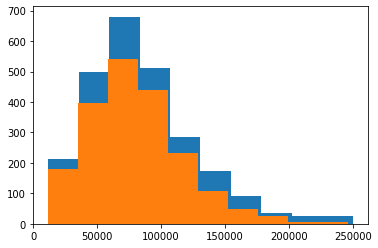

In [17]:
import matplotlib.pyplot as plt

def mean_comm_median_inc(comm_list):
    mean_comm_inc = []
    for comm in comm_list:
        index_list = []
        for k in comm:
            index = ma_data.index[ma_data.census_block_group == k].tolist()
            index_list.extend(index)
        df = ma_data.iloc[index_list]
        inc = df.median_hh_income.mean()
        mean_comm_inc.append(inc)
    plot = plt.hist(mean_comm_inc)
    return mean_comm_inc, plot


feb_inc, feb_inc_plot = mean_comm_median_inc(feb_comm_list2)
apr_inc, apr_inc_plot = mean_comm_median_inc(apr_comm_list2)

# print(feb_inc, apr_inc)

Here I provide a simple chart of the distribution of mean median income across the communities in two time periods. The red graph shows a decrease in the number of communities and a slightly fatter curve. This is a crude measure and probably not that meaningful - I included it here as proof of work for further analysis that can be done with the data. Below I map the largest communities in each month

In [18]:
largest_comm_feb, largest_comm_apr = max(feb_comm_list2, key=len), max(apr_comm_list2, key=len)
print(len(largest_comm_feb), len(largest_comm_apr))

1871 2508


In [19]:
import folium
clon, clat = ma_data.longitude.mean(), ma_data.latitude.mean()
m = folium.Map(location=(clon, clat), zoom_start=11)

display(m)
# the map doesn't show here for me... I wonder if this is a problem with the package since this is just the basic map...

In [21]:
def add_points(comm, color):
    index_list = []
    for c in comm:
        index = ma_data.index[ma_data.census_block_group == c].tolist()
        index_list.extend(index)
    for i in index_list:
        comm_long, comm_lat = ma_data.loc[i, "longitude"], ma_data.loc[i, "latitude"]
        folium.CircleMarker((comm_lat, comm_long), opacity = 0.5, color=color, radius=2, weight=2).add_to(m)

add_points(largest_comm_feb, "red")
add_points(largest_comm_apr, "blue")
display(m)